# Soccer Analytics: Defensive xG (expected goals conceded) by team

## Objectives
1. **Analyze defensive xG (expected goals conceded) by team**

### Calculate xG For and Against Each Team

For each match:
- **Offensive xG**: Sum of all shot xG values for a team
- **Defensive xG**: Sum of all shot xG values for the opponent (xG conceded)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

DATA_DIR = Path("..") / "data"
POLYMARKET_DIR = DATA_DIR / "Polymarket"
STATSBOMB_DIR = DATA_DIR / "StatsBomb"


In [26]:
# StatsBomb files
sb_matches = pd.read_parquet(STATSBOMB_DIR / "matches.parquet")
sb_events = pd.read_parquet(STATSBOMB_DIR / "events.parquet")
sb_lineups = pd.read_parquet(STATSBOMB_DIR / "lineups.parquet")

print("StatsBomb Data Loaded:")
print(f"  Matches: {len(sb_matches):,} rows")
print(f"  Events: {len(sb_events):,} rows")
print(f"  Lineups: {len(sb_lineups):,} rows")

StatsBomb Data Loaded:
  Matches: 3,464 rows
  Events: 12,188,949 rows
  Lineups: 165,820 rows


In [27]:
# Filter events to only shots with xG data
shots = sb_events[
    (sb_events['type'] == 'Shot') & 
    (sb_events['shot_statsbomb_xg'].notna())
].copy()

print(f"Total shots with xG data: {len(shots):,}")
print(f"\nxG Statistics:")
print(shots['shot_statsbomb_xg'].describe())

Total shots with xG data: 88,023

xG Statistics:
count    88023.000000
mean         0.106599
std          0.149922
min          0.000180
25%          0.027747
50%          0.054884
75%          0.110167
max          0.995122
Name: shot_statsbomb_xg, dtype: float64


In [28]:
# Calculate xG per team per match
match_xg = shots.groupby(['match_id', 'team']).agg({
    'shot_statsbomb_xg': 'sum'
}).reset_index()

match_xg.columns = ['match_id', 'team', 'xG']

print("Sample match xG:")
match_xg.head(10)

Sample match xG:


,match_id,team,xG
0,7298,Chelsea FCW,2.972968
1,7298,Manchester City WFC,1.107514
2,7430,North Carolina Courage,2.152028
3,7430,Washington Spirit,0.948216
4,7443,OL Reign,1.857566
5,7443,Portland Thorns,3.867489
6,7444,Chicago Red Stars,0.580654
7,7444,North Carolina Courage,3.300426
8,7445,Utah Royals,0.747666
9,7445,Washington Spirit,1.643781


### Join with Match Metadata to Get Offensive and Defensive xG

In [29]:
# For each match, we need both teams' xG
# Create separate dataframes for home and away
home_xg = match_xg.merge(
    sb_matches[['match_id', 'home_team', 'away_team', 'match_date', 'competition_name']],
    on='match_id'
)
home_xg = home_xg[home_xg['team'] == home_xg['home_team']]
home_xg = home_xg.rename(columns={'xG': 'home_xG'})

away_xg = match_xg.merge(
    sb_matches[['match_id', 'home_team', 'away_team']],
    on='match_id'
)
away_xg = away_xg[away_xg['team'] == away_xg['away_team']]
away_xg = away_xg.rename(columns={'xG': 'away_xG'})

# Combine
match_xg_full = home_xg[['match_id', 'home_team', 'away_team', 'match_date', 'competition_name', 'home_xG']].merge(
    away_xg[['match_id', 'away_xG']],
    on='match_id',
    how='outer'
)

# Fill NaN with 0 (no shots = 0 xG)
match_xg_full['home_xG'] = match_xg_full['home_xG'].fillna(0)
match_xg_full['away_xG'] = match_xg_full['away_xG'].fillna(0)

print("Match-level xG (offensive for each team):")
match_xg_full.head(10)

Match-level xG (offensive for each team):


,match_id,home_team,away_team,match_date,competition_name,home_xG,away_xG
0,7298,Manchester City WFC,Chelsea FCW,2018-02-24,FA Women's Super League,1.107514,2.972968
1,7430,Washington Spirit,North Carolina Courage,2018-04-15,NWSL,0.948216,2.152028
2,7443,Portland Thorns,OL Reign,2018-05-05,NWSL,3.867489,1.857566
3,7444,North Carolina Courage,Chicago Red Stars,2018-05-06,NWSL,3.300426,0.580654
4,7445,Utah Royals,Washington Spirit,2018-05-06,NWSL,0.747666,1.643781
5,7451,North Carolina Courage,Washington Spirit,2018-05-13,NWSL,1.867851,1.185288
6,7456,NJ/NY Gotham FC,North Carolina Courage,2018-05-20,NWSL,1.835904,3.184335
7,7457,Orlando Pride,North Carolina Courage,2018-05-24,NWSL,1.713852,4.390527
8,7471,Orlando Pride,North Carolina Courage,2018-06-30,NWSL,0.982378,1.370617
9,7472,OL Reign,Portland Thorns,2018-07-01,NWSL,1.747613,1.293514


### Create Team-Level Dataset with Offensive and Defensive xG

In [30]:
# Create records for home team
home_records = match_xg_full[['match_id', 'match_date', 'competition_name', 'home_team', 'away_team', 'home_xG', 'away_xG']].copy()
home_records.columns = ['match_id', 'match_date', 'competition_name', 'team', 'opponent', 'xG_for', 'xG_against']
home_records['location'] = 'Home'

# Create records for away team
away_records = match_xg_full[['match_id', 'match_date', 'competition_name', 'away_team', 'home_team', 'away_xG', 'home_xG']].copy()
away_records.columns = ['match_id', 'match_date', 'competition_name', 'team', 'opponent', 'xG_for', 'xG_against']
away_records['location'] = 'Away'

# Combine
team_match_xg = pd.concat([home_records, away_records], ignore_index=True)

print(f"\nTotal team-match records: {len(team_match_xg):,}")
print("\nSample records:")
team_match_xg.head(10)


Total team-match records: 6,928

Sample records:


,match_id,match_date,competition_name,team,opponent,xG_for,xG_against,location
0,7298,2018-02-24,FA Women's Super League,Manchester City WFC,Chelsea FCW,1.107514,2.972968,Home
1,7430,2018-04-15,NWSL,Washington Spirit,North Carolina Courage,0.948216,2.152028,Home
2,7443,2018-05-05,NWSL,Portland Thorns,OL Reign,3.867489,1.857566,Home
3,7444,2018-05-06,NWSL,North Carolina Courage,Chicago Red Stars,3.300426,0.580654,Home
4,7445,2018-05-06,NWSL,Utah Royals,Washington Spirit,0.747666,1.643781,Home
5,7451,2018-05-13,NWSL,North Carolina Courage,Washington Spirit,1.867851,1.185288,Home
6,7456,2018-05-20,NWSL,NJ/NY Gotham FC,North Carolina Courage,1.835904,3.184335,Home
7,7457,2018-05-24,NWSL,Orlando Pride,North Carolina Courage,1.713852,4.390527,Home
8,7471,2018-06-30,NWSL,Orlando Pride,North Carolina Courage,0.982378,1.370617,Home
9,7472,2018-07-01,NWSL,OL Reign,Portland Thorns,1.747613,1.293514,Home


### Aggregate Defensive xG by Team

In [31]:
# Calculate team statistics
team_defensive_stats = team_match_xg.groupby('team').agg({
    'match_id': 'count',
    'xG_for': 'sum',
    'xG_against': 'sum'  # This is defensive xG!
}).reset_index()

team_defensive_stats.columns = ['team', 'matches_played', 'total_xG_for', 'total_xG_against']

# Calculate per-match averages
team_defensive_stats['avg_xG_for_per_match'] = team_defensive_stats['total_xG_for'] / team_defensive_stats['matches_played']
team_defensive_stats['avg_xG_against_per_match'] = team_defensive_stats['total_xG_against'] / team_defensive_stats['matches_played']

# Calculate net xG (offensive - defensive)
team_defensive_stats['net_xG_per_match'] = team_defensive_stats['avg_xG_for_per_match'] - team_defensive_stats['avg_xG_against_per_match']

# Sort by best defensive record (lowest xG against)
team_defensive_stats = team_defensive_stats.sort_values('avg_xG_against_per_match')

print("\n=== BEST DEFENSIVE TEAMS (Lowest xG Conceded Per Match) ===")
print(team_defensive_stats.head(20).to_string(index=False))


=== BEST DEFENSIVE TEAMS (Lowest xG Conceded Per Match) ===
               team  matches_played  total_xG_for  total_xG_against  avg_xG_for_per_match  avg_xG_against_per_match  net_xG_per_match
      Argentina U20               1      1.726488          0.446860              1.726488                  0.446860          1.279627
        Chelsea FCW              57    143.258179         37.175602              2.513301                  0.652204          1.861098
               Ajax               3      6.156651          1.966975              2.052217                  0.655658          1.396559
       Nashville SC               1      0.550400          0.666627              0.550400                  0.666627         -0.116227
           FC Porto               1      0.499920          0.682694              0.499920                  0.682694         -0.182774
        Arsenal WFC              57    132.706146         41.539841              2.328178                  0.728769          1.599409
 

### Visualize Defensive Performance

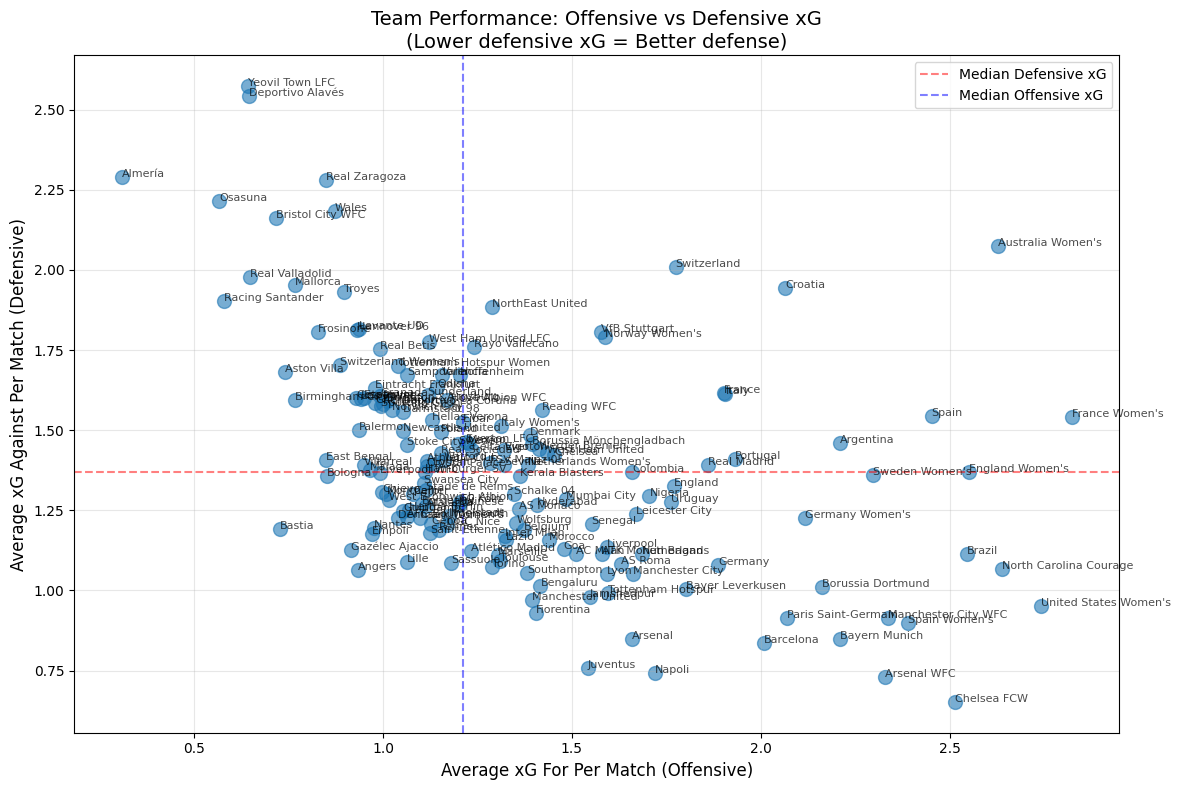

In [32]:
# Filter to teams with at least 10 matches for meaningful stats
teams_min_matches = team_defensive_stats[team_defensive_stats['matches_played'] >= 10].copy()

# Plot: Offensive vs Defensive xG
plt.figure(figsize=(12, 8))
plt.scatter(
    teams_min_matches['avg_xG_for_per_match'],
    teams_min_matches['avg_xG_against_per_match'],
    s=100,
    alpha=0.6
)

# Add team labels for top teams
for idx, row in teams_min_matches.iterrows():
    plt.annotate(
        row['team'],
        (row['avg_xG_for_per_match'], row['avg_xG_against_per_match']),
        fontsize=8,
        alpha=0.7
    )

# Add reference lines
plt.axhline(teams_min_matches['avg_xG_against_per_match'].median(), color='red', linestyle='--', alpha=0.5, label='Median Defensive xG')
plt.axvline(teams_min_matches['avg_xG_for_per_match'].median(), color='blue', linestyle='--', alpha=0.5, label='Median Offensive xG')

plt.xlabel('Average xG For Per Match (Offensive)', fontsize=12)
plt.ylabel('Average xG Against Per Match (Defensive)', fontsize=12)
plt.title('Team Performance: Offensive vs Defensive xG\n(Lower defensive xG = Better defense)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('offensive_vs_defensive_xg.png', dpi=300, bbox_inches='tight')
plt.show()

# print("\nChart saved as 'offensive_vs_defensive_xg.png'")

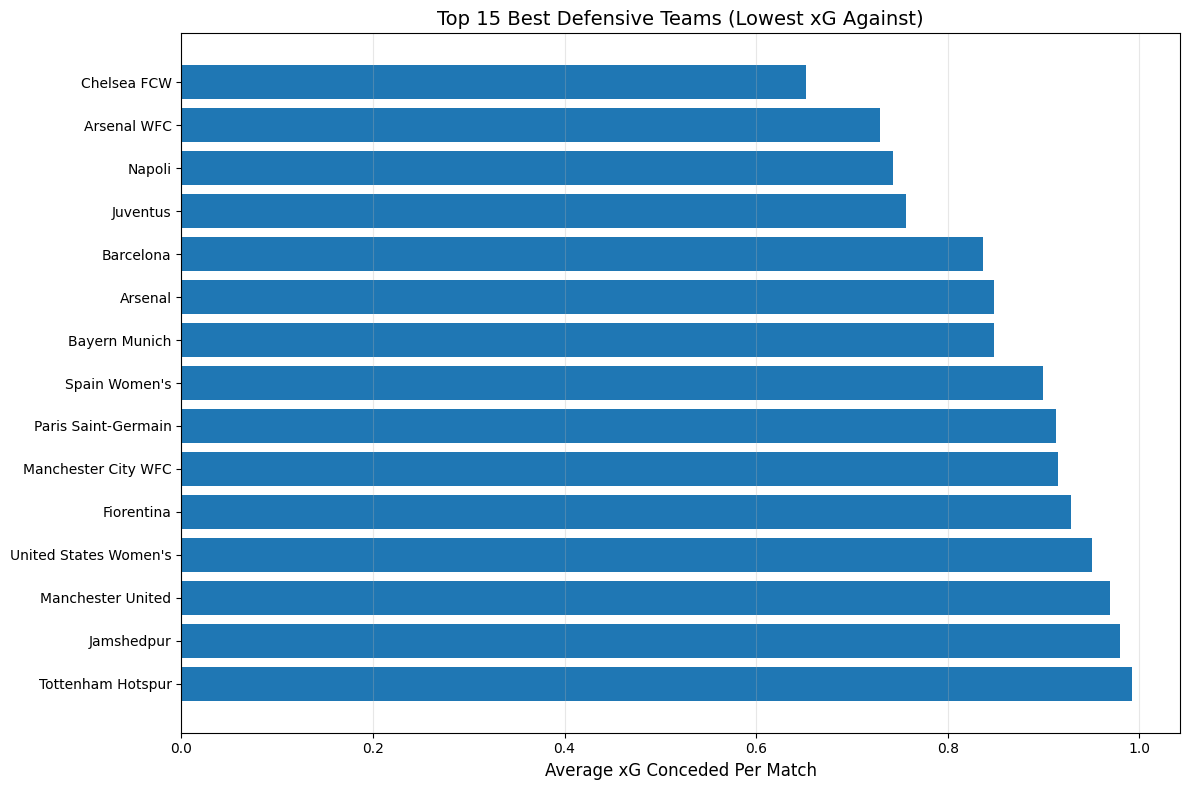

In [33]:
# Bar chart: Top 15 Best Defenses
top_defenses = teams_min_matches.nsmallest(15, 'avg_xG_against_per_match')

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_defenses)), top_defenses['avg_xG_against_per_match'])
plt.yticks(range(len(top_defenses)), top_defenses['team'])
plt.xlabel('Average xG Conceded Per Match', fontsize=12)
plt.title('Top 15 Best Defensive Teams (Lowest xG Against)', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
# plt.savefig('top_defenses.png', dpi=300, bbox_inches='tight')
plt.show()

# print("\nChart saved as 'top_defenses.png'")

### Advanced Analysis - Specific Team Deep Dive

Let's analyze Arsenal as an example.

In [34]:
# Select team to analyze
TEAM_TO_ANALYZE = 'Arsenal'

arsenal_data = team_match_xg[team_match_xg['team'] == TEAM_TO_ANALYZE].copy()
arsenal_data = arsenal_data.sort_values('match_date')

print(f"\n=== {TEAM_TO_ANALYZE} Analysis ===")
print(f"Total matches: {len(arsenal_data)}")
print(f"Average xG For: {arsenal_data['xG_for'].mean():.2f}")
print(f"Average xG Against: {arsenal_data['xG_against'].mean():.2f}")
print(f"Net xG per match: {(arsenal_data['xG_for'].mean() - arsenal_data['xG_against'].mean()):.2f}")

print("\nRecent matches:")
arsenal_data[['match_date', 'opponent', 'location', 'xG_for', 'xG_against']].tail(10)


=== Arsenal Analysis ===
Total matches: 76
Average xG For: 1.66
Average xG Against: 0.85
Net xG per match: 0.81

Recent matches:


,match_date,opponent,location,xG_for,xG_against
4702,2016-03-05,Tottenham Hotspur,Away,0.732763,1.248720
4364,2016-03-19,Everton,Away,1.830370,0.458831
1038,2016-04-02,Watford,Home,2.576715,0.432057
4625,2016-04-09,West Ham United,Away,1.843034,1.257756
929,2016-04-17,Crystal Palace,Home,1.736554,0.387562
1204,2016-04-21,West Bromwich Albion,Home,1.318571,0.734106
4374,2016-04-24,Sunderland,Away,1.338112,0.501765
1104,2016-04-30,Norwich City,Home,0.814684,0.815282
4698,2016-05-08,Manchester City,Away,0.887442,0.738292
961,2016-05-15,Aston Villa,Home,2.922745,0.301122


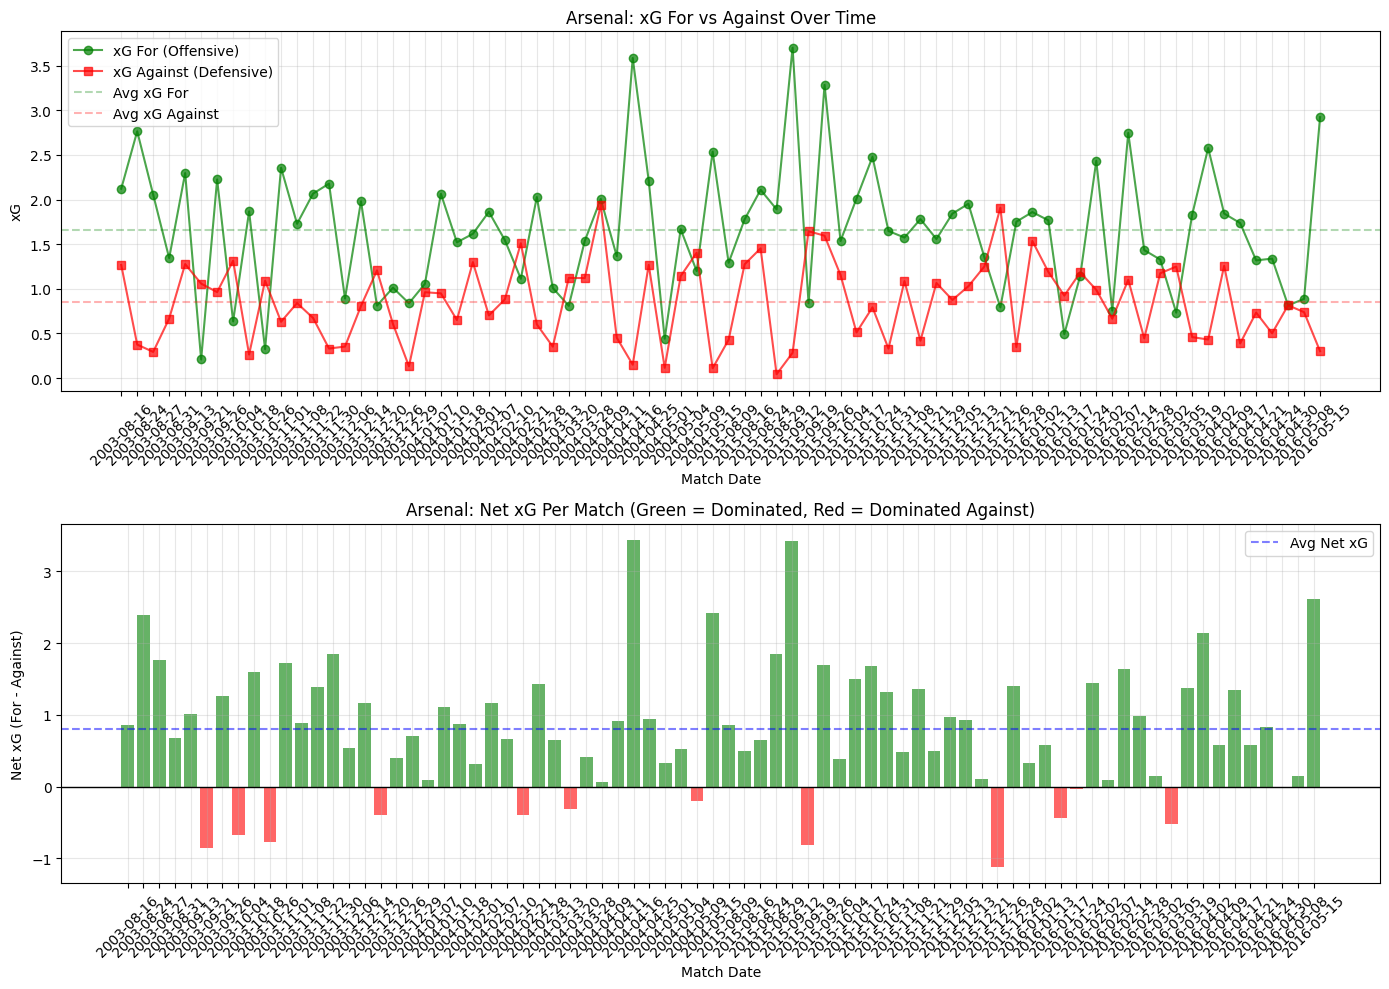

In [35]:
# Plot Arsenal's xG trend over time
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: xG For and Against over time
ax[0].plot(arsenal_data['match_date'], arsenal_data['xG_for'], marker='o', label='xG For (Offensive)', color='green', alpha=0.7)
ax[0].plot(arsenal_data['match_date'], arsenal_data['xG_against'], marker='s', label='xG Against (Defensive)', color='red', alpha=0.7)
ax[0].axhline(arsenal_data['xG_for'].mean(), color='green', linestyle='--', alpha=0.3, label='Avg xG For')
ax[0].axhline(arsenal_data['xG_against'].mean(), color='red', linestyle='--', alpha=0.3, label='Avg xG Against')
ax[0].set_xlabel('Match Date')
ax[0].set_ylabel('xG')
ax[0].set_title(f'{TEAM_TO_ANALYZE}: xG For vs Against Over Time')
ax[0].legend()
ax[0].grid(True, alpha=0.3)
ax[0].tick_params(axis='x', rotation=45)

# Plot 2: Net xG (xG_for - xG_against)
arsenal_data['net_xG'] = arsenal_data['xG_for'] - arsenal_data['xG_against']
colors = ['green' if x > 0 else 'red' for x in arsenal_data['net_xG']]
ax[1].bar(arsenal_data['match_date'], arsenal_data['net_xG'], color=colors, alpha=0.6)
ax[1].axhline(0, color='black', linewidth=1)
ax[1].axhline(arsenal_data['net_xG'].mean(), color='blue', linestyle='--', alpha=0.5, label='Avg Net xG')
ax[1].set_xlabel('Match Date')
ax[1].set_ylabel('Net xG (For - Against)')
ax[1].set_title(f'{TEAM_TO_ANALYZE}: Net xG Per Match (Green = Dominated, Red = Dominated Against)')
ax[1].legend()
ax[1].grid(True, alpha=0.3)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
# plt.savefig(f'{TEAM_TO_ANALYZE.lower()}_xg_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# print(f"\nChart saved as '{TEAM_TO_ANALYZE.lower()}_xg_analysis.png'")

### Shot Quality Analysis 

xG per Shot 

Teams by Shot Quality (avg xG per shot):
                  team   total_xG  total_shots  avg_xG_per_shot
74            Congo DR  23.923197          108         0.221511
253       South Africa  19.244862           91         0.211482
81               Cádiz   4.718754           23         0.205163
135             Huesca   3.754031           19         0.197581
55              Canada  19.450558          109         0.178445
239             Russia  14.579036           84         0.173560
24   Australia Women's  28.917898          169         0.171112
71       Clermont Foot   4.840976           29         0.166930
138           Hércules   2.134987           13         0.164230
290          Venezuela  10.061128           62         0.162276
96     England Women's  66.324379          411         0.161373
13           Argentina  48.612926          309         0.157323
268     Sweden Women's  52.848080          357         0.148034
77             Croatia  43.368370          295         0.147011

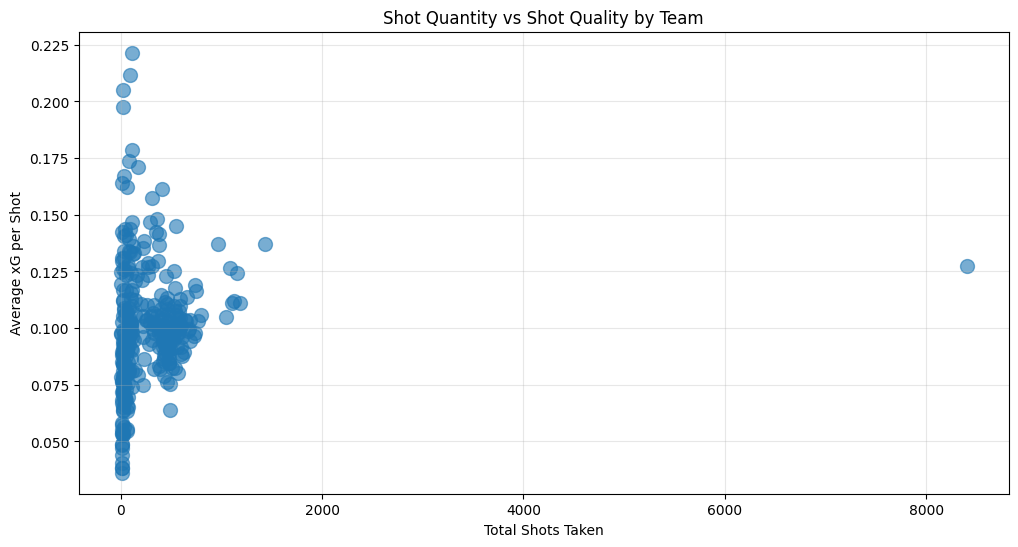

In [36]:
# Calculate average xG value per shot (higher = better shot quality)
shot_quality = sb_events[
    (sb_events['type'] == 'Shot') & 
    (sb_events['shot_statsbomb_xg'].notna())
].copy()

team_shot_quality = shot_quality.groupby('team').agg({
    'shot_statsbomb_xg': ['sum', 'count', 'mean']
}).reset_index()

team_shot_quality.columns = ['team', 'total_xG', 'total_shots', 'avg_xG_per_shot']
team_shot_quality = team_shot_quality.sort_values('avg_xG_per_shot', ascending=False)

print("Teams by Shot Quality (avg xG per shot):")
print(team_shot_quality.head(15))

# Visualize
plt.figure(figsize=(12, 6))
plt.scatter(team_shot_quality['total_shots'], 
           team_shot_quality['avg_xG_per_shot'],
           alpha=0.6, s=100)
plt.xlabel('Total Shots Taken')
plt.ylabel('Average xG per Shot')
plt.title('Shot Quantity vs Shot Quality by Team')
plt.grid(True, alpha=0.3)
plt.show()

Shot Location Heatmap

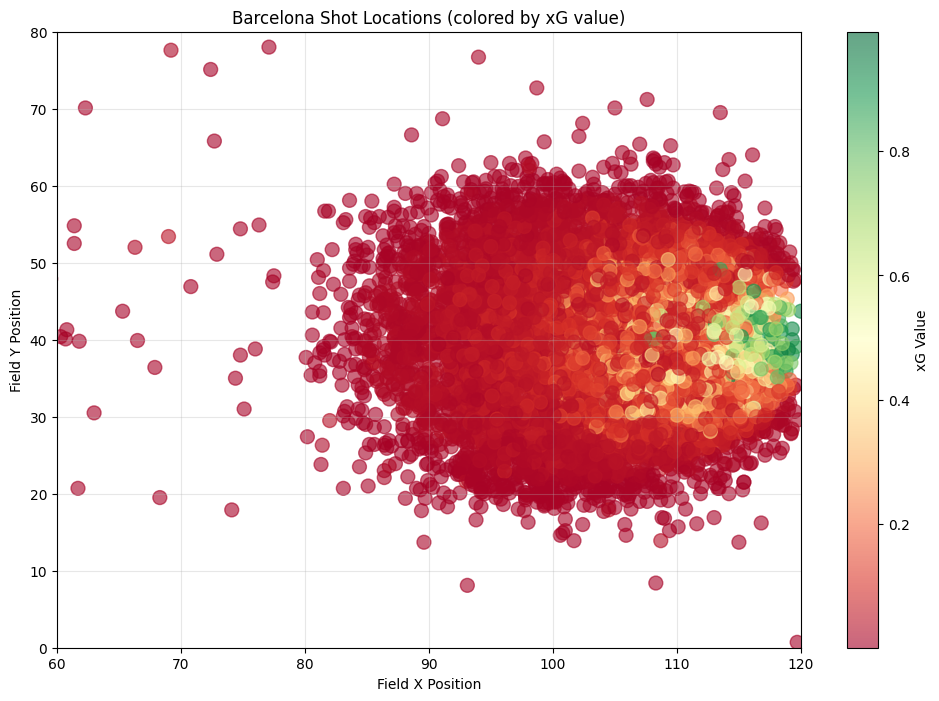

In [37]:
# Analyze where teams take shots from
import numpy as np

# Filter to one team for example
team_name = 'Barcelona'
team_shots = shot_quality[shot_quality['team'] == team_name].copy()

plt.figure(figsize=(12, 8))
plt.scatter(team_shots['location_x'], 
           team_shots['location_y'],
           c=team_shots['shot_statsbomb_xg'],
           s=100,
           alpha=0.6,
           cmap='RdYlGn')
plt.colorbar(label='xG Value')
plt.xlabel('Field X Position')
plt.ylabel('Field Y Position')
plt.title(f'{team_name} Shot Locations (colored by xG value)')
plt.xlim(60, 120)  # Focus on attacking half
plt.ylim(0, 80)
plt.grid(True, alpha=0.3)
plt.show()